In [45]:
# PSP System with RL Agent
%pip install simpy numpy matplotlib scipy stable_baselines3 torch gym tensorboard standard-imghdr
%load_ext tensorboard
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from gym import spaces
import gym

# Simulation parameters
SIM_TIME = 20_000
WARM_UP = 2_000
WC_IDS = [1, 2, 3, 4, 5, 6]
FAMILY_PROBS = {1: 0.10, 2: 0.52, 3: 0.38}
PROCESSING_PARAMS = {1: (2, 2), 2: (4, 0.5), 3: (6, 1/6)}
ROUTING = {
    1: {1: 1.0, 2: 1.0, 4: 1.0, 5: 1.0, 6: 1.0},
    2: {1: 0.8, 2: 0.8, 3: 1.0, 4: 0.8, 5: 0.8, 6: 0.75},
    3: {3: 1.0, 6: 0.75}
}
ARRIVAL_RATE = 0.65
DUE_TIME = (30, 50)
DECISION_INTERVAL = ARRIVAL_RATE/2
TARGET_THROUGHPUT = 0.65  # PUSH system's throughput

class Job:
    next_id = 1
    
    def __init__(self, env, family):
        self.jid = Job.next_id
        Job.next_id += 1
        self.family = family
        self.arrival_time = env.now
        self.due_date = self.arrival_time + random.uniform(DUE_TIME[0], DUE_TIME[1])
        self.completion_time : None | float = None
        self.release_time = None
        
        # Precompute routing and workload
        self.routing = {}
        self.remaining_workload = 0.0
        for wc_id, prob in ROUTING[family].items():
            if random.random() < prob:
                alpha, beta = PROCESSING_PARAMS[family]
                processing_time = random.gammavariate(alpha, beta)
                self.routing[wc_id] = processing_time
                self.remaining_workload += processing_time

    def __repr__(self):
        return f"Job {self.jid} (F{self.family}) due @ {self.due_date:.2f} workload={self.remaining_workload:.2f}"

Note: you may need to restart the kernel to use updated packages.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
from collections import defaultdict


class ManufacturingEnv(gym.Env):
    def __init__(self):
        super(ManufacturingEnv, self).__init__()
        self.observation_space = spaces.Box(
            low=0, 
            high=np.inf,
            shape=(24,), 
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(2)  # 0=hold, 1=release one
        self.env: simpy.Environment
        self.psp = deque()
        self.wcs: dict[int, simpy.Resource]
        self.stats: dict
        self.gamma = 0.99
        self.decision_interval = DECISION_INTERVAL
        self.wc_queues = {wc_id: [] for wc_id in WC_IDS}
        self.job_arrival_event: simpy.Event
        self.reset()
        
    def reset_stats(self):
        self.stats = {
            'generated': 0,
            'completed_jobs': [],
            'active_jobs_time_at_level': defaultdict(float),
            'last_active_jobs_update_time': 0.0,
            'last_active_jobs_count': 0,
            'total_remaining_workload': 0.0,
            'workload_events': [],  # (time, workload) tuples
            'flow_times' : [], # (completion_time, flow time)
            'wc_busy_time': {wc: 0 for wc in WC_IDS},
            'queue_times': {wc: [] for wc in WC_IDS},
            'tardiness': [],
            'earliness': [],
            'tardiness_over_time': [],   # (completion_time, tardiness)
            'earliness_over_time': [],    # (completion_time, earliness)
            'family_counts': {1: 0, 2: 0, 3: 0},
            'family_tardiness': {1: [], 2: [], 3: []},
            'family_earliness': {1: [], 2: [], 3: []},
            'arrival_times': {1: [], 2: [], 3: []},
            'released_jobs': 0
        }
    
    def reset(self):
        self.env = simpy.Environment()
        self.job_arrival_event = self.env.event()
        self.psp = deque()
        self.wcs = {wc_id: simpy.Resource(self.env) for wc_id in WC_IDS}
        self.wc_queues = {wc_id: [] for wc_id in WC_IDS}
        self.reset_stats()
        Job.next_id = 1
        self.active_jobs=[]
        
        self.env.process(self.job_generator())
        return self._get_state()
    
    def _get_state(self):
        """Build state vector"""
        # state = np.zeros(18, dtype=np.float32)
        state = np.zeros(24, dtype=np.float32)
        
        # 1. Queue lengths at each WC (indices 0-5)
        for i, wc_id in enumerate(WC_IDS):
            state[i] = len(self.wcs[wc_id].queue)
        
        # 2. Workload at each WC (indices 6-11)
        for i, wc_id in enumerate(WC_IDS):
            total_workload = 0
            for job in self.wc_queues[wc_id]:
                total_workload += job.routing[wc_id]
            state[6 + i] = total_workload
        
        # 3. PSP count (index 12)
        state[12] = len(self.psp)
        
        if self.psp:
            # Get most urgent job
            job = min(self.psp, key=lambda j: j.due_date)
            
            # 4. One-hot family encoding (indices 13-15)
            state[13 + job.family - 1] = 1
            
            # 5. Due date remaining (index 16)
            state[16] = job.due_date - self.env.now
            
            # 6. Wait time (index 17)
            state[17] = self.env.now - job.arrival_time
        
            # 7. processing time at each WC (indices 18-23)
            for wc_id, processing_time in job.routing.items():
                state[18 + wc_id - 1] = processing_time

        return state
    
    def _release_job(self):
        job = min(self.psp, key=lambda j: j.due_date)
        self.psp.remove(job)
        job.release_time = self.env.now  # Track release time
        self.env.process(self.process_job(job))
        self.stats['released_jobs'] += 1
    
    def step(self, action):
        if action == 1 and self.psp:
            self._release_job()
        
        start_time = self.env.now
        self.env.run(until=self.job_arrival_event)
        
        reward = self._calculate_reward()
        next_state = self._get_state()
        done = self.env.now >= SIM_TIME
        info = {}
        
        return next_state, reward, done, info
    
    def _calculate_reward(self):
        """Penalize tardiness and earliness of last completed jobs and tardiness of uncompleted jobs"""
        uncompleted_jobs_tardiness = np.sum([max(self.env.now - job.due_date, 0) for job in self.active_jobs]) if self.active_jobs else 0.0

        completed_job_tardiness = np.sum(self.stats['tardiness'][-50:]) if self.stats['tardiness'] else 0.0
        completed_job_earliness = np.sum(self.stats['earliness'][-50:]) if self.stats['earliness'] else 0.0

        return -uncompleted_jobs_tardiness -completed_job_tardiness -completed_job_earliness


    
    def job_generator(self):
        while True:
            family = random.choices([1, 2, 3], weights=list(FAMILY_PROBS.values()))[0]
            job = Job(self.env, family)
            self.psp.append(job)
            self.active_jobs.append(job)
            self.stats['generated'] += 1
            self.stats['family_counts'][family] += 1
            self.stats['arrival_times'][family].append(self.env.now)
            
            self.job_arrival_event.succeed()
            self.job_arrival_event = self.env.event()
            
            interarrival = random.expovariate(ARRIVAL_RATE)
            yield self.env.timeout(interarrival)
    
    def process_job(self, job: Job):
        time_spent = self.env.now - self.stats['last_active_jobs_update_time']
        self.stats['active_jobs_time_at_level'][self.stats['last_active_jobs_count']] += time_spent
        self.stats['last_active_jobs_update_time'] = self.env.now
        self.stats['last_active_jobs_count'] += 1  # Job enters system

        self.stats['total_remaining_workload'] += job.remaining_workload
        self.stats['workload_events'].append((self.env.now, self.stats['total_remaining_workload']))
        
        for wc_id, processing_time in job.routing.items():
            wc = self.wcs[wc_id]
            with wc.request() as req:
                self.wc_queues[wc_id].append(job)
                queue_start = self.env.now
                yield req
                self.wc_queues[wc_id].remove(job)
                
                queue_time = self.env.now - queue_start
                self.stats['queue_times'][wc_id].append(queue_time)

                self.stats['total_remaining_workload'] -= processing_time
                job.remaining_workload -= processing_time
                self.stats['workload_events'].append((self.env.now, self.stats['total_remaining_workload']))
                
                yield self.env.timeout(processing_time)

                self.stats['wc_busy_time'][wc_id] += processing_time
        
        # Job completion
        job.completion_time = self.env.now
        self.stats['completed_jobs'].append(job)
        if self.env.now > WARM_UP:
            time_spent = self.env.now - self.stats['last_active_jobs_update_time']
            self.stats['active_jobs_time_at_level'][self.stats['last_active_jobs_count']] += time_spent
        self.stats['last_active_jobs_update_time'] = self.env.now
        self.stats['last_active_jobs_count'] -= 1  # Job leaves system

        self.stats['flow_times'].append((self.env.now, job.completion_time - job.arrival_time))
        
        tardiness = max(0, job.completion_time - job.due_date)
        earliness = max(0, job.due_date - job.completion_time)

        self.active_jobs.remove(job)
        
        if self.env.now > WARM_UP:
            self.stats['tardiness'].append(tardiness)
            self.stats['earliness'].append(earliness)
            self.stats['tardiness_over_time'].append((self.env.now, tardiness))
            self.stats['earliness_over_time'].append((self.env.now, earliness))
            self.stats['family_tardiness'][job.family].append(tardiness)
            self.stats['family_earliness'][job.family].append(earliness)
        
    def get_kpis(self):
        """Compute KPIs from simulation statistics"""
        # Average active_jobs
        total_time = SIM_TIME - WARM_UP
        
        # Filter active job data to post-warm-up period
        active_jobs_time = self.stats['active_jobs_time_at_level']
        
        weighted_sum = sum(
            level * duration 
            for level, duration in active_jobs_time.items()
        )

        # Calculate average total remaining workload
        events = sorted(self.stats['workload_events'], key=lambda x: x[0])
        total_time = self.env.now
        integral = 0.0
        
        if events:
            # Handle warm-up period
            start_index = 0
            prev_workload = 0
            for i, (time, workload) in enumerate(events):
                if time > WARM_UP:
                    start_index = i
                    break
                prev_workload = workload
            
            # Calculate integral from WARM_UP to end
            if start_index > 0:
                integral += prev_workload * (events[start_index][0] - WARM_UP)
            
            for i in range(start_index, len(events)-1):
                t1, w1 = events[i]
                t2, w2 = events[i+1]
                integral += w1 * (t2 - t1)
            
            if events and events[-1][0] < total_time:
                integral += events[-1][1] * (total_time - events[-1][0])
        
        avg_workload = integral / max(1, total_time - WARM_UP)
        
        avg_jobs_in_system = weighted_sum / total_time if total_time > 0 else 0
        
        # Tardiness/Earliness/Flow Time
        avg_tardiness = np.mean(self.stats['tardiness']) if self.stats['tardiness'] else 0
        avg_earliness = np.mean(self.stats['earliness']) if self.stats['earliness'] else 0
        
        avg_flow_times = np.mean([flow_time for timestamp, flow_time in self.stats['flow_times'] if timestamp > WARM_UP])
        
        # Throughput
        elapsed_time = max(1, self.env.now - WARM_UP)
        completed_after_warmup = [j for j in self.stats['completed_jobs'] if j.completion_time > WARM_UP]
        throughput = len(completed_after_warmup) / elapsed_time
        
        # Utilization
        utilizations = {wc: self.stats['wc_busy_time'][wc] / max(1, self.env.now) for wc in WC_IDS}
        
        return {
            'Average jobs in system (L)': avg_jobs_in_system,
            'Average Total Remaining Workload': avg_workload,
            'Average Tardiness': avg_tardiness,
            'Average Earliness': avg_earliness,
            'Average Flow Times': avg_flow_times,
            'Throughput': throughput,
            'WC Utilization': utilizations,
            'Jobs Released': self.stats['released_jobs'],
            'Jobs Completed': len(self.stats['completed_jobs'])
        }

In [47]:
from stable_baselines3.common.vec_env import VecNormalize

# Create environment
env = SubprocVecEnv([lambda: ManufacturingEnv() for _ in range(16)])
env = VecNormalize(env, norm_obs=True, norm_reward=True)

final_model = PPO("MlpPolicy", env, batch_size=128, verbose=1, tensorboard_log="./rl_agent_tensorboard/", device='cpu') # PPO_40
final_model.learn(total_timesteps=2_000_000)

# Save model
final_model.save("optimized_production_agent_alt")
env.save("optimized_vec_normalize.pkl_alt")

print("\nFinal model trained and saved!")

/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Ba

Using cpu device
Logging to ./rl_agent_tensorboard/PPO_41


/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


------------------------------
| time/              |       |
|    fps             | 5191  |
|    iterations      | 1     |
|    time_elapsed    | 6     |
|    total_timesteps | 32768 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2609        |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.005367907 |
|    clip_fraction        | 0.0314      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | -0.0521     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.85        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00243    |
|    value_loss           | 2.15        |
-----------------------------------------
---------------------------


Running policy visualization...


/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


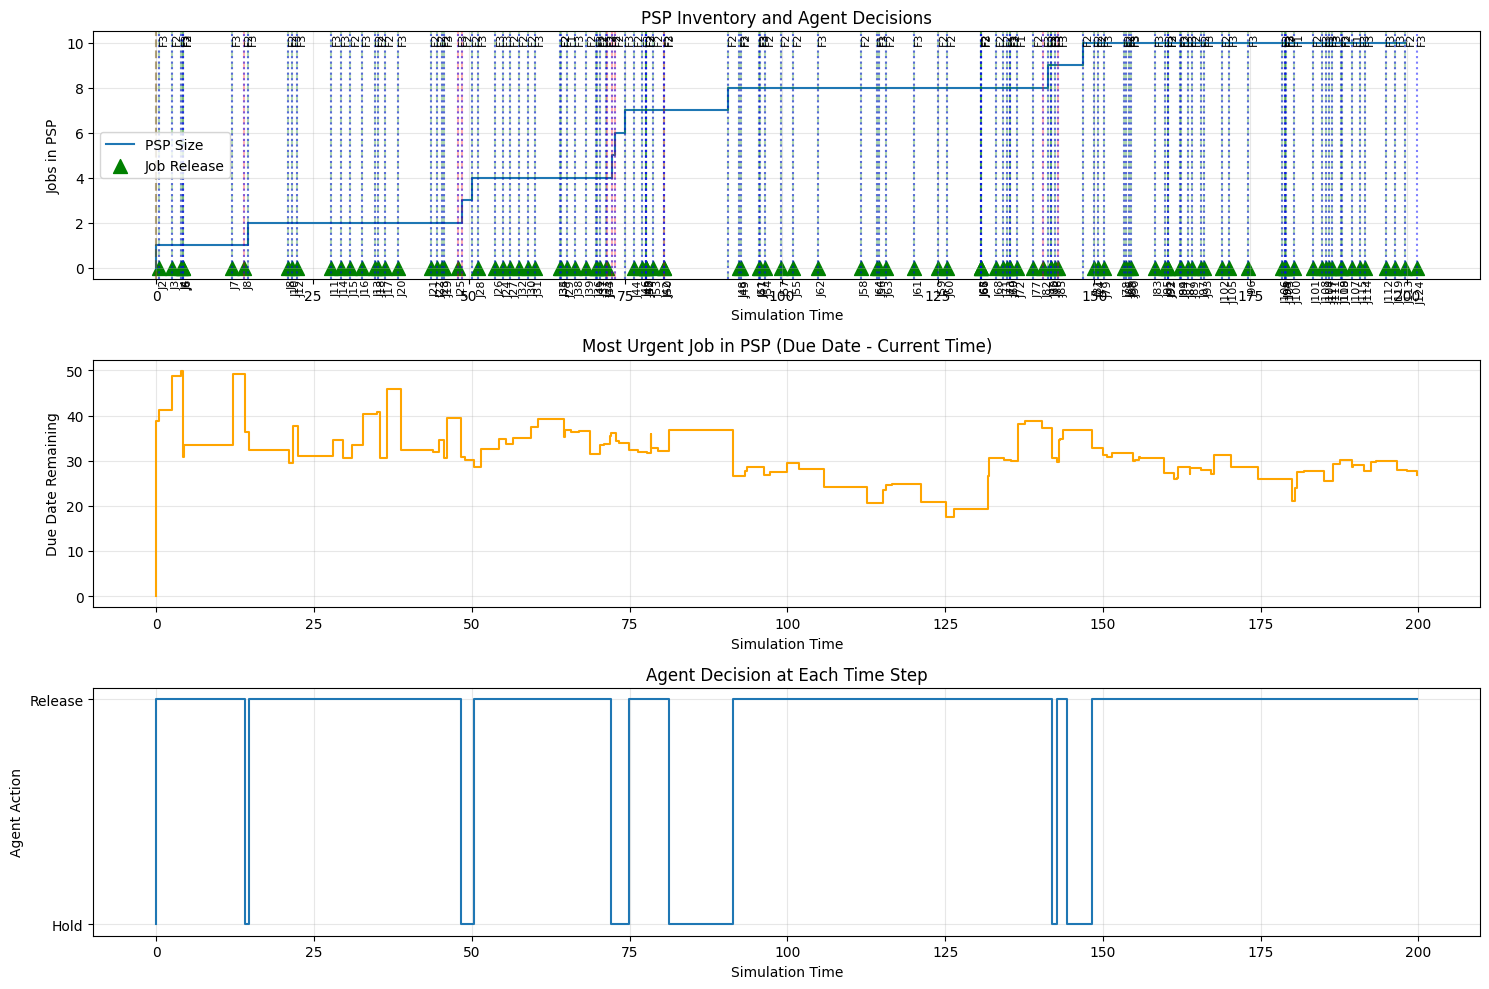


Decision Log (First 20 decisions):
Time      PSP Size  Due Remaining  Action    
0.00      0         N/A            HOLD      
0.00      1         38.75          RELEASE   
0.45      1         41.22          RELEASE   
2.42      1         48.88          RELEASE   
3.96      1         49.90          RELEASE   
4.24      1         30.75          RELEASE   
4.30      1         33.59          RELEASE   
12.08     1         49.27          RELEASE   
14.06     1         36.43          HOLD      
14.61     2         32.46          RELEASE   
20.99     2         29.50          RELEASE   
21.61     2         37.63          RELEASE   
22.46     2         31.10          RELEASE   
27.98     2         34.58          RELEASE   
29.50     2         30.70          RELEASE   
31.02     2         33.52          RELEASE   
32.81     2         40.41          RELEASE   
34.93     2         40.70          RELEASE   
35.40     2         30.59          RELEASE   
36.59     2         45.94          RELEASE  

In [48]:
# Visualize the learned policy
def visualize_policy(episode_duration=500):
    # Load environment and model
    eval_env = VecNormalize.load("optimized_vec_normalize_alt.pkl", DummyVecEnv([lambda: ManufacturingEnv()]))
    eval_env.training = False
    model = PPO.load("optimized_production_agent_alt", env=eval_env, device='cpu')
    
    # Create environment instance
    env = ManufacturingEnv()
    state = env.reset()
    done = False
    
    # Data collection structures
    decision_points = []
    psp_sizes = []
    due_dates = []
    actions = []
    job_arrivals = []
    releases = []
    
    print("\nRunning policy visualization...")
    while not done and env.env.now < episode_duration:
        # Record pre-decision state
        current_time = env.env.now
        psp_size = len(env.psp)
        urgent_due = min(j.due_date for j in env.psp) if env.psp else 0
        
        # Get agent action
        action, _ = model.predict(state, deterministic=True)
        
        # Execute action
        next_state, _, done, _ = env.step(action)
        state = next_state
        
        # Record data
        decision_points.append(current_time)
        psp_sizes.append(psp_size)
        due_dates.append(urgent_due - current_time if urgent_due else 0)
        actions.append(action)
        
        # Track new arrivals and releases
        if env.stats['arrival_times']:
            for family, times in env.stats['arrival_times'].items():
                for t in times:
                    if t > current_time and t <= env.env.now:
                        job_arrivals.append((t, family))
        
        if action == 1 and env.psp:
            releases.append((env.env.now, min(env.psp, key=lambda j: j.due_date).jid))

    # Visualization
    plt.figure(figsize=(15, 10))
    
    # PSP size and decisions
    plt.subplot(3, 1, 1)
    plt.step(decision_points, psp_sizes, where='post', label='PSP Size')
    plt.xlabel('Simulation Time')
    plt.ylabel('Jobs in PSP')
    plt.title('PSP Inventory and Agent Decisions')
    
    # Mark decision points
    for i, (t, action) in enumerate(zip(decision_points, actions)):
        color = 'green' if action == 1 else 'red'
        plt.axvline(t, color=color, alpha=0.3, linestyle='--')
    
    # Mark job arrivals
    for t, family in job_arrivals:
        plt.axvline(t, color='blue', alpha=0.5, linestyle=':')
        plt.text(t, max(psp_sizes)*1.05, f'F{family}', rotation=90, 
                 verticalalignment='top', fontsize=8)
    
    # Mark releases
    release_times = [t for t, _ in releases]
    release_jids = [jid for _, jid in releases]
    plt.scatter(release_times, [0]*len(release_times), color='green', 
                marker='^', s=100, label='Job Release')
    
    for t, jid in releases:
        plt.text(t, -0.5, f'J{jid}', rotation=90, 
                 verticalalignment='top', fontsize=8)
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Due date urgency
    plt.subplot(3, 1, 2)
    plt.step(decision_points, due_dates, where='post', color='orange')
    plt.xlabel('Simulation Time')
    plt.ylabel('Due Date Remaining')
    plt.title('Most Urgent Job in PSP (Due Date - Current Time)')
    plt.grid(True, alpha=0.3)
    
    # Action types
    plt.subplot(3, 1, 3)
    plt.step(decision_points, actions, where='post')
    plt.yticks([0, 1], ['Hold', 'Release'])
    plt.xlabel('Simulation Time')
    plt.ylabel('Agent Action')
    plt.title('Agent Decision at Each Time Step')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print decision log
    print("\nDecision Log (First 20 decisions):")
    print(f"{'Time':<10}{'PSP Size':<10}{'Due Remaining':<15}{'Action':<10}")
    for i in range(min(20, len(decision_points))):
        t = decision_points[i]
        size = psp_sizes[i]
        due_rem = f"{due_dates[i]:.2f}" if due_dates[i] else "N/A"
        action = "RELEASE" if actions[i] == 1 else "HOLD"
        print(f"{t:<10.2f}{size:<10}{due_rem:<15}{action:<10}")

# Run visualization
visualize_policy(episode_duration=200)

In [49]:
# Evaluate Optimized Agent
from stable_baselines3.common.vec_env import VecNormalize

def evaluate_optimized_agent(num_episodes: int):
    # Load environment stats
    eval_env = DummyVecEnv([lambda: ManufacturingEnv()])
    eval_env = VecNormalize.load("optimized_vec_normalize_alt.pkl", eval_env)
    eval_env.training = False
    eval_env.norm_reward = False

    # Load model
    model = PPO.load("optimized_production_agent_alt", env=eval_env, device='cpu')
    
    results = []
    
    for i in range(num_episodes):
        random.seed(42 + i)

        print(f"Running evaluation episode {i+1}/5")
        env = ManufacturingEnv()
        state = env.reset()
        done = False
        
        while not done:
            action, _ = model.predict(state, deterministic=True)
            state, _, done, _ = env.step(action)
        
        kpis = env.get_kpis()
        results.append(kpis)
        
        print(f"Episode {i+1} Results:")
        for k, v in kpis.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for subk, subv in v.items():
                    print(f"    {subk}: {subv:.4f}")
            else:
                print(f"  {k}: {v:.4f}")
    
    return results

# Run evaluation
optimized_results = evaluate_optimized_agent(num_episodes=5)

Running evaluation episode 1/5


/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Episode 1 Results:
  Average jobs in system (L): 29.0478
  Average Total Remaining Workload: 134.3145
  Average Tardiness: 130.5430
  Average Earliness: 0.0000
  Average Flow Times: 170.6158
  Throughput: 0.6459
  WC Utilization:
    1: 0.7887
    2: 0.7952
    3: 0.9202
    4: 0.7911
    5: 0.7894
    6: 0.9479
  Jobs Released: 12919.0000
  Jobs Completed: 12909.0000
Running evaluation episode 2/5
Episode 2 Results:
  Average jobs in system (L): 24.9584
  Average Total Remaining Workload: 124.5022
  Average Tardiness: 114.6656
  Average Earliness: 0.0000
  Average Flow Times: 154.6812
  Throughput: 0.6406
  WC Utilization:
    1: 0.7990
    2: 0.7985
    3: 0.9009
    4: 0.7928
    5: 0.7808
    6: 0.9416
  Jobs Released: 12792.0000
  Jobs Completed: 12761.0000
Running evaluation episode 3/5
Episode 3 Results:
  Average jobs in system (L): 22.8205
  Average Total Remaining Workload: 118.6495
  Average Tardiness: 110.2455
  Average Earliness: 0.0000
  Average Flow Times: 150.2506
  Thr

In [50]:
# Compare with PUSH System
def run_push_simulation(num_episodes=5):
    """Run the original PUSH system for comparison"""
    results = []
    
    for i in range(num_episodes):
        random.seed(42 + i)
        print(f"Running PUSH simulation {i+1}/{num_episodes}")
        
        env = simpy.Environment()
        wcs = {wc_id: simpy.Resource(env) for wc_id in WC_IDS}
        stats = {
            'generated': 0,
            'completed_jobs': [],
            'active_jobs_time_at_level': defaultdict(float),
            'last_active_jobs_update_time': 0.0,
            'last_active_jobs_count': 0,
            'total_remaining_workload': 0.0,
            'workload_events': [],  # (time, workload) tuples
            'wc_busy_time': {wc: 0 for wc in WC_IDS},
            'queue_times': {wc: [] for wc in WC_IDS},
            'tardiness': [],
            'earliness': [],
            'flow_times': [],
            'family_counts': {1: 0, 2: 0, 3: 0},
            'arrival_times': {1: [], 2: [], 3: []}
        }
        
        env.process(job_generator(env, wcs, stats))
        env.run(until=SIM_TIME)
        
        # Compute KPIs
        # Average active_jobs
        total_time = SIM_TIME - WARM_UP
        
        # Filter active job data to post-warm-up period
        active_jobs_time = stats['active_jobs_time_at_level']
        
        weighted_sum = sum(
            level * duration 
            for level, duration in active_jobs_time.items()
        )
        
        avg_jobs_in_system = weighted_sum / total_time if total_time > 0 else 0

        # Compute average total remaining workload
        events = sorted(stats['workload_events'], key=lambda x: x[0])
        integral = 0.0
        prev_time = 0
        prev_workload = 0
        
        for time, workload in events:
            if time > WARM_UP:
                integral += prev_workload * (time - max(prev_time, WARM_UP))
            prev_time = time
            prev_workload = workload
        
        if prev_time < SIM_TIME:
            integral += prev_workload * (SIM_TIME - max(prev_time, WARM_UP))
        
        total_time = SIM_TIME - WARM_UP
        avg_workload = integral / total_time if total_time > 0 else 0
        
        avg_tardiness = np.mean(stats['tardiness']) if stats['tardiness'] else 0
        avg_earliness = np.mean(stats['earliness']) if stats['earliness'] else 0
        
        avg_flow_time = np.mean([flow_time for timestamp, flow_time in stats['flow_times'] if timestamp > WARM_UP])
        
        elapsed_time = SIM_TIME - WARM_UP
        completed_after_warmup = [j for j in stats['completed_jobs'] if j.completion_time > WARM_UP]
        throughput = len(completed_after_warmup) / elapsed_time
        
        utilizations = {wc: stats['wc_busy_time'][wc] / SIM_TIME for wc in WC_IDS}
        
        kpis = {
            'Average jobs in system (L)': avg_jobs_in_system,
            'Average Total Remaining Workload': avg_workload,
            'Average Tardiness': avg_tardiness,
            'Average Earliness': avg_earliness,
            'Average Flow Times': avg_flow_time,
            'Throughput': throughput,
            'WC Utilization': utilizations,
            'Jobs Released': stats['generated'],
            'Jobs Completed': len(stats['completed_jobs'])
        }
        
        results.append(kpis)
        
        print(f"PUSH Episode {i+1} Results:")
        for k, v in kpis.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for subk, subv in v.items():
                    print(f"    {subk}: {subv:.4f}")
            else:
                print(f"  {k}: {v:.4f}")
    
    return results

def job_generator(env, wcs, stats):
    while True:
        family = random.choices([1, 2, 3], weights=list(FAMILY_PROBS.values()))[0]
        job = Job(env, family)
        job.release_time = job.arrival_time  # Immediate release in PUSH
        env.process(run_job(env, wcs, stats, job))
        interarrival = random.expovariate(ARRIVAL_RATE)
        yield env.timeout(interarrival)

def run_job(env, wcs, stats, job):
    stats['generated'] += 1
    if env.now > WARM_UP:
        time_spent = env.now - stats['last_active_jobs_update_time']
        stats['active_jobs_time_at_level'][stats['last_active_jobs_count']] += time_spent
    stats['last_active_jobs_update_time'] = env.now
    stats['last_active_jobs_count'] += 1  # Job enters system
    stats['family_counts'][job.family] += 1
    stats['arrival_times'][job.family].append(env.now)

    # Update workload stats
    stats['total_remaining_workload'] += job.remaining_workload
    stats['workload_events'].append((env.now, stats['total_remaining_workload']))

    for wc_id, processing_time in job.routing.items():
        wc = wcs[wc_id]
        with wc.request() as req:
            queue_start = env.now
            yield req
            queue_time = env.now - queue_start
            stats['queue_times'][wc_id].append(queue_time)
            
            stats['total_remaining_workload'] -= processing_time
            job.remaining_workload -= processing_time
            stats['workload_events'].append((env.now, stats['total_remaining_workload']))

            yield env.timeout(processing_time)
            stats['wc_busy_time'][wc_id] += processing_time

    job.completion_time = env.now
    flow_time = job.completion_time - job.arrival_time
    stats['completed_jobs'].append(job)
    if env.now > WARM_UP:
        time_spent = env.now - stats['last_active_jobs_update_time']
        stats['active_jobs_time_at_level'][stats['last_active_jobs_count']] += time_spent
    stats['last_active_jobs_update_time'] = env.now
    stats['last_active_jobs_count'] -= 1  # Job leaves system
    
    stats['flow_times'].append((env.now, flow_time))
    
    tardiness = max(0, job.completion_time - job.due_date)
    earliness = max(0, job.due_date - job.completion_time)
    
    if env.now > WARM_UP:
        stats['tardiness'].append(tardiness)
        stats['earliness'].append(earliness)

# Run comparisons
push_results = run_push_simulation(num_episodes=5)

Running PUSH simulation 1/5
PUSH Episode 1 Results:
  Average jobs in system (L): 32.4250
  Average Total Remaining Workload: 141.6323
  Average Tardiness: 18.0716
  Average Earliness: 7.8968
  Average Flow Times: 50.2374
  Throughput: 0.6472
  WC Utilization:
    1: 0.7952
    2: 0.8013
    3: 0.9261
    4: 0.7968
    5: 0.7956
    6: 0.9547
  Jobs Released: 13010.0000
  Jobs Completed: 12990.0000
Running PUSH simulation 2/5
PUSH Episode 2 Results:
  Average jobs in system (L): 28.8044
  Average Total Remaining Workload: 135.3119
  Average Tardiness: 14.7704
  Average Earliness: 10.0527
  Average Flow Times: 44.7278
  Throughput: 0.6427
  WC Utilization:
    1: 0.8052
    2: 0.8038
    3: 0.9077
    4: 0.7988
    5: 0.7871
    6: 0.9485
  Jobs Released: 12883.0000
  Jobs Completed: 12845.0000
Running PUSH simulation 3/5
PUSH Episode 3 Results:
  Average jobs in system (L): 25.4778
  Average Total Remaining Workload: 121.7984
  Average Tardiness: 10.0553
  Average Earliness: 10.1699
  

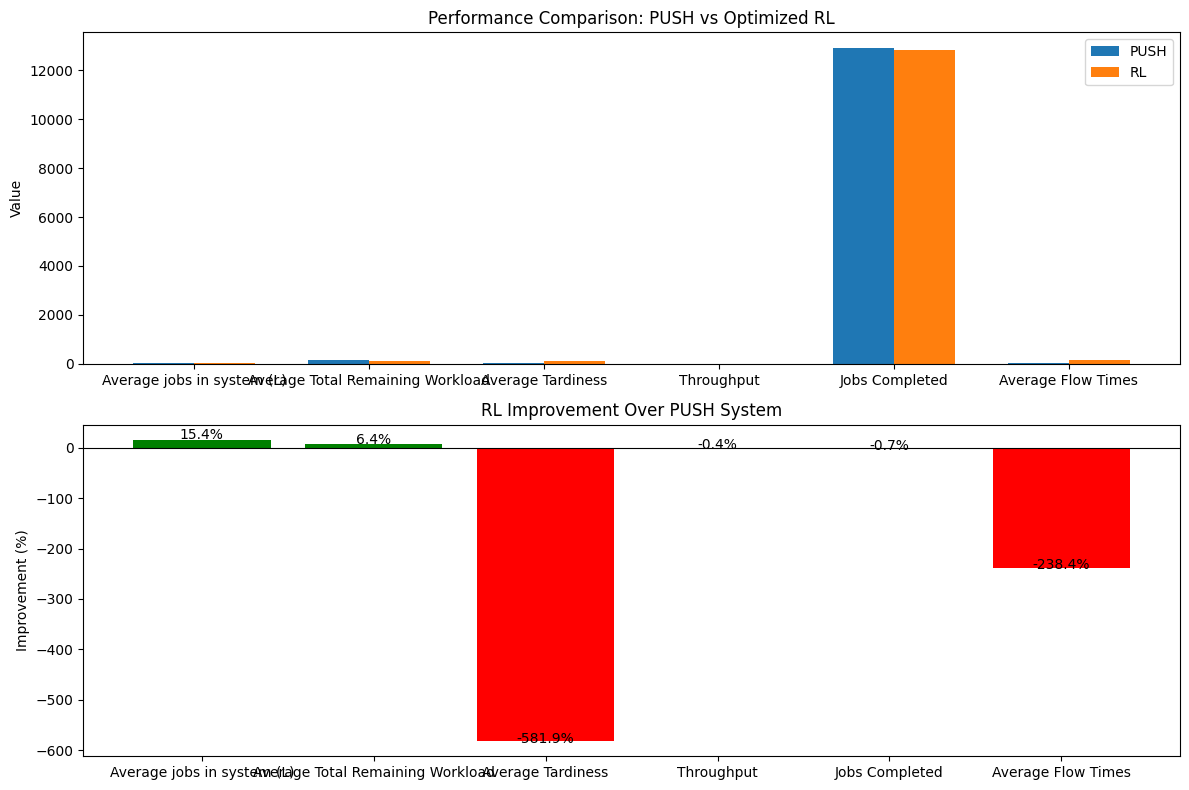


Performance Summary:
Metric                              PUSH       RL         Improvement
----------------------------------------------------------------------
Average jobs in system (L)          32.4120    27.4284    15.4      %
Average Total Remaining Workload    142.8513   133.6486   6.4       %
Average Tardiness                   19.0852    130.1468   -581.9    %
Throughput                          0.6451     0.6426     -0.4      %
Jobs Completed                      12908.8000 12816.0000 -0.7      %
Average Flow Times                  50.2815    170.1710   -238.4    %


In [51]:
# Visualization
def compare_results(push_results, rl_results):
    metrics = ['Average jobs in system (L)', 'Average Total Remaining Workload', 'Average Tardiness', 'Throughput', 'Jobs Completed', 'Average Flow Times']
    
    push_means = {m: np.mean([r[m] for r in push_results]) for m in metrics}
    rl_means = {m: np.mean([r[m] for r in rl_results]) for m in metrics}
    
    improvements = {}
    for m in metrics:
        if push_means[m] != 0:
            improvement = (push_means[m] - rl_means[m]) / push_means[m] * 100
        else:
            improvement = 0
        improvements[m] = improvement

    improvements['Throughput'] *= -1
    improvements['Jobs Completed'] *= -1
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, [push_means[m] for m in metrics], width, label='PUSH')
    plt.bar(x + width/2, [rl_means[m] for m in metrics], width, label='RL')
    
    plt.ylabel('Value')
    plt.title('Performance Comparison: PUSH vs Optimized RL')
    plt.xticks(x, metrics)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    colors = ['green' if i > 0 else 'red' for i in improvements.values()]
    plt.bar(metrics, list(improvements.values()), color=colors)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.ylabel('Improvement (%)')
    plt.title('RL Improvement Over PUSH System')
    
    for i, v in enumerate(improvements.values()):
        plt.text(i, v + (1 if v > 0 else -3), f"{v:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nPerformance Summary:")
    print(f"{'Metric':<35} {'PUSH':<10} {'RL':<10} {'Improvement':<10}")
    print("-" * 70)
    for m in metrics:
        print(f"{m:<35} {push_means[m]:<10.4f} {rl_means[m]:<10.4f} {improvements[m]:<10.1f}%")
    
    return improvements

final_improvements = compare_results(push_results, optimized_results)

In [52]:
# Confidence Interval Calculation for RL Agent System
import scipy.stats as stats

def run_rl_replication():
    """Run one replication of the RL agent simulation and return KPIs"""
    # Create a single environment instance
    env = ManufacturingEnv()

    # Load the normalization stats and wrap the environment
    norm_env = VecNormalize.load("optimized_vec_normalize_alt.pkl", DummyVecEnv([lambda: ManufacturingEnv()]))
    norm_env.training = False
    norm_env.norm_reward = False

    # Load the trained model
    model = PPO.load("optimized_production_agent_alt", env=norm_env, device='cpu')
    state = env.reset()
    done = False
    while not done:
        action, _ = model.predict(state, deterministic=True)
        state, _, done, _ = env.step(action)
    kpis = env.get_kpis()
    return {
        'Average jobs in system (L)': kpis['Average jobs in system (L)'],
        'Average Total Remaining Workload': kpis['Average Total Remaining Workload'],
        'Average Tardiness': kpis['Average Tardiness'],
        'Average Earliness': kpis['Average Earliness'],
        'Throughput': kpis['Throughput']
    }

def compute_confidence_intervals(metrics, alpha=0.05, gamma=0.05, n0=5):
    """
    Compute confidence intervals using sequential procedure
    metrics: list of metric names to analyze
    alpha: significance level (1-alpha confidence interval)
    gamma: relative error threshold
    n0: initial number of replications
    max_reps: maximum number of replications to prevent infinite loops
    """
    data = {metric: [] for metric in metrics}
    n = n0
    
    # Initial replications
    print(f"Running initial {n0} replications...")
    for _ in range(n0):
        rep_data = run_rl_replication()
        for metric in metrics:
            data[metric].append(rep_data[metric])
    
    # Sequential procedure
    while True:
        print(f"\n--- n = {n} ---")
        all_metrics_meet_criteria = True
        results = {}
        
        for metric in metrics:
            values = np.array(data[metric])
            mean = np.mean(values)
            var = np.var(values, ddof=1)  # Sample variance
            
            # Handle case where variance is zero
            if var == 0:
                std_err = 0
                delta = 0
            else:
                std_err = np.sqrt(var / n)
                t_val = stats.t.ppf(1 - alpha/2, n-1)
                delta = t_val * std_err
            
            # Relative error check (handle near-zero means)
            if abs(mean) < 0.1:  # Avoid division by zero
                meets_criteria = delta < 0.01  # Absolute threshold for near-zero means
            else:
                meets_criteria = (delta / abs(mean)) <= gamma
            
            results[metric] = {
                'mean': mean,
                'variance': var,
                'delta': delta,
                'meets_criteria': meets_criteria
            }
            
            print(f"{metric}:")
            print(f"  Mean = {mean:.4f}, Var = {var:.4f}, Δ = {delta:.4f}")
            print(f"  Relative error = {delta/abs(mean):.4f} (Criteria met: {meets_criteria})")
            
            if not meets_criteria:
                all_metrics_meet_criteria = False
        
        # Check if all metrics meet the criteria
        if all_metrics_meet_criteria:
            print("\nAll metrics meet the relative error criteria!")
            final_results = {}
            for metric in metrics:
                final_results[metric] = {
                    'point_estimate': results[metric]['mean'],
                    'ci_lower': results[metric]['mean'] - results[metric]['delta'],
                    'ci_upper': results[metric]['mean'] + results[metric]['delta'],
                    'n': n
                }
            return final_results
        
        # Run additional replication if needed
        n += 1
        print(f"\nRunning additional replication (n = {n})...")
        rep_data = run_rl_replication()
        for metric in metrics:
            data[metric].append(rep_data[metric])

# Compute confidence intervals
metrics_to_analyze = ['Average jobs in system (L)', 'Average Total Remaining Workload', 'Average Tardiness', 'Average Earliness', 'Throughput']
confidence_intervals = compute_confidence_intervals(metrics_to_analyze)

# Display results
if confidence_intervals:
    print("\n\n=== Final Confidence Intervals ===")
    print(f"{'Metric':<35} {'Point Estimate':<15} {'95% CI':<25} {'Replications'}")
    print("-" * 70)
    for metric, ci in confidence_intervals.items():
        point_est = ci['point_estimate']
        ci_str = f"[{ci['ci_lower']:.4f}, {ci['ci_upper']:.4f}]"
        print(f"{metric:<35} {point_est:<15.4f} {ci_str:<25} {ci['n']}")
else:
    print("Failed to compute confidence intervals")

Running initial 5 replications...


/home/matteo/anaconda3/envs/unimore_aai/lib/python3.13/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



--- n = 5 ---
Average jobs in system (L):
  Mean = 27.7477, Var = 12.4623, Δ = 4.3833
  Relative error = 0.1580 (Criteria met: False)
Average Total Remaining Workload:
  Mean = 138.5074, Var = 174.8646, Δ = 16.4193
  Relative error = 0.1185 (Criteria met: False)
Average Tardiness:
  Mean = 135.8736, Var = 68.4236, Δ = 10.2709
  Relative error = 0.0756 (Criteria met: False)
Average Earliness:
  Mean = 0.0000, Var = 0.0000, Δ = 0.0000
  Relative error = nan (Criteria met: True)
Throughput:
  Mean = 0.6459, Var = 0.0001, Δ = 0.0103
  Relative error = 0.0160 (Criteria met: True)

Running additional replication (n = 6)...


/tmp/ipykernel_1798112/2208933671.py:84: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  Relative error = {delta/abs(mean):.4f} (Criteria met: {meets_criteria})")



--- n = 6 ---
Average jobs in system (L):
  Mean = 29.2788, Var = 24.0364, Δ = 5.1451
  Relative error = 0.1757 (Criteria met: False)
Average Total Remaining Workload:
  Mean = 144.0017, Var = 321.0181, Δ = 18.8027
  Relative error = 0.1306 (Criteria met: False)
Average Tardiness:
  Mean = 144.7431, Var = 526.7468, Δ = 24.0856
  Relative error = 0.1664 (Criteria met: False)
Average Earliness:
  Mean = 0.0000, Var = 0.0000, Δ = 0.0000
  Relative error = nan (Criteria met: True)
Throughput:
  Mean = 0.6472, Var = 0.0001, Δ = 0.0085
  Relative error = 0.0131 (Criteria met: True)

Running additional replication (n = 7)...

--- n = 7 ---
Average jobs in system (L):
  Mean = 28.5805, Var = 23.4438, Δ = 4.4780
  Relative error = 0.1567 (Criteria met: False)
Average Total Remaining Workload:
  Mean = 140.9606, Var = 332.2548, Δ = 16.8580
  Relative error = 0.1196 (Criteria met: False)
Average Tardiness:
  Mean = 144.2455, Var = 440.6889, Δ = 19.4149
  Relative error = 0.1346 (Criteria met: Fa

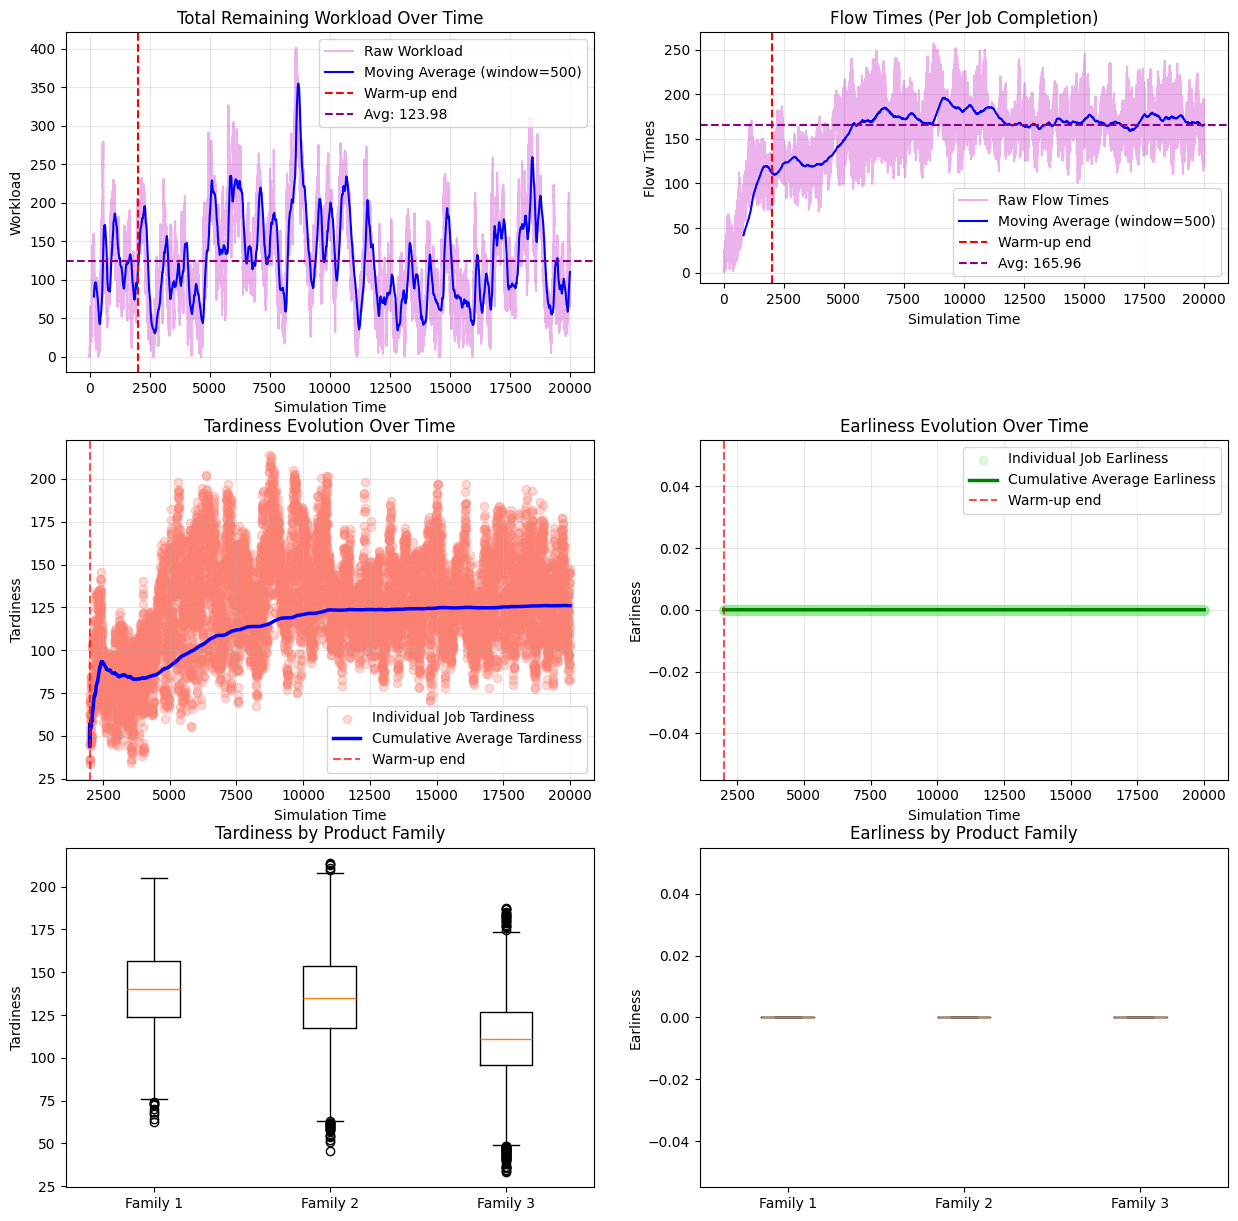

In [53]:
def run_simulation():
    # Create a single environment instance
    env = ManufacturingEnv()

    # Load the normalization stats and wrap the environment
    norm_env = VecNormalize.load("optimized_vec_normalize_alt.pkl", DummyVecEnv([lambda: ManufacturingEnv()]))
    norm_env.training = False
    norm_env.norm_reward = False

    # Load the trained model
    model = PPO.load("optimized_production_agent_alt", env=norm_env, device='cpu')
    state = env.reset()
    done = False
    while not done:
        action, _ = model.predict(state, deterministic=True)
        state, _, done, _ = env.step(action)

    return env.stats, env.get_kpis()

def moving_average(data, window_size=100):
    """Calculate moving average with specified window size"""
    if len(data) < window_size:
        return data
    
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def graphs(stats, kpis):
    plt.figure(figsize=(15, 15))

    # Total Remaining Workload over time
    plt.subplot(3, 2, 1)
    if stats['workload_events']:
        # Sort events by time
        events = sorted(stats['workload_events'], key=lambda x: x[0])
        times, workloads = zip(*events)
        
        # Create step plot for raw workload
        plt.step(times, workloads, where='post', color='m', alpha=0.3, label='Raw Workload')
        
        # Calculate and plot moving average
        window_size = 500  # Adjust this to control smoothness
        if len(workloads) > window_size:
            smoothed = moving_average(workloads, window_size)
            # Adjust times to match smoothed data length
            plt.plot(times[window_size-1:], smoothed, 'b-', linewidth=1.5, 
                    label=f'Moving Average (window={window_size})')
        
        plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
        plt.axhline(kpis['Average Total Remaining Workload'], color='darkmagenta', 
                   linestyle='--', label=f'Avg: {kpis["Average Total Remaining Workload"]:.2f}')
        plt.title('Total Remaining Workload Over Time')
        plt.xlabel('Simulation Time')
        plt.ylabel('Workload')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No workload data available', 
                 ha='center', va='center', fontsize=12)
        plt.title('Total Remaining Workload Over Time')

    # Flow time graph
    plt.subplot(4, 2, 2)
    if stats['flow_times']:
        # Sort events by time
        events = sorted(stats['flow_times'], key=lambda x: x[0])
        times, flow_times = zip(*events)
        
        # Create step plot for raw flow_times
        plt.step(times, flow_times, where='post', color='m', alpha=0.3, label='Raw Flow Times')
        
        # Calculate and plot moving average
        window_size = 500  # Adjust this to control smoothness
        if len(flow_times) > window_size:
            smoothed = moving_average(flow_times, window_size)
            # Adjust times to match smoothed data length
            plt.plot(times[window_size-1:], smoothed, 'b-', linewidth=1.5, 
                    label=f'Moving Average (window={window_size})')
        
        plt.axvline(WARM_UP, color='r', linestyle='--', label='Warm-up end')
        plt.axhline(kpis['Average Flow Times'], color='darkmagenta', 
                   linestyle='--', label=f'Avg: {kpis["Average Flow Times"]:.2f}')
        plt.title('Flow Times (Per Job Completion)')
        plt.xlabel('Simulation Time')
        plt.ylabel('Flow Times')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No flow_times data available', 
                 ha='center', va='center', fontsize=12)
        plt.title('Flow Times (Per Job Completion)')

    # plot tardiness over time
    plt.subplot(3,2,3)

    if not stats['tardiness_over_time']:
        plt.text(0.5, 0.5, 'No tardiness data available', 
                    ha='center', va='center', fontsize=16)
        plt.title('Tardiness Evolution Over Time')
        return

    # Extract and sort data
    times, tardiness = zip(*stats['tardiness_over_time'])
    sorted_idx = np.argsort(times)
    times = np.array(times)[sorted_idx]
    tardiness = np.array(tardiness)[sorted_idx]

    # Calculate cumulative average
    cum_avg = np.cumsum(tardiness) / (np.arange(len(tardiness)) + 1)

    # Create plot
    plt.scatter(times, tardiness, alpha=0.3, color='salmon', 
                label='Individual Job Tardiness')
    plt.plot(times, cum_avg, 'b-', linewidth=2.5, 
                label='Cumulative Average Tardiness')

    plt.axvline(WARM_UP, color='r', linestyle='--', alpha=0.7, label='Warm-up end')
    plt.title('Tardiness Evolution Over Time')
    plt.xlabel('Simulation Time')
    plt.ylabel('Tardiness')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # plot earliness over time
    plt.subplot(3,2,4)

    if not stats['earliness_over_time']:
        plt.text(0.5, 0.5, 'No earliness data available', 
                ha='center', va='center', fontsize=16)
        plt.title('Earliness Evolution Over Time')
        return

    # Extract and sort data
    times, earliness = zip(*stats['earliness_over_time'])
    sorted_idx = np.argsort(times)
    times = np.array(times)[sorted_idx]
    earliness = np.array(earliness)[sorted_idx]

    # Calculate cumulative average
    cum_avg = np.cumsum(earliness) / (np.arange(len(earliness)) + 1)

    # Create plot
    plt.scatter(times, earliness, alpha=0.3, color='lightgreen', 
                label='Individual Job Earliness')
    plt.plot(times, cum_avg, 'g-', linewidth=2.5, 
            label='Cumulative Average Earliness')

    plt.axvline(WARM_UP, color='r', linestyle='--', alpha=0.7, label='Warm-up end')
    plt.title('Earliness Evolution Over Time')
    plt.xlabel('Simulation Time')
    plt.ylabel('Earliness')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Family tardiness
    plt.subplot(3,2,5)
    family_tardiness = [
        stats['family_tardiness'][1],
        stats['family_tardiness'][2],
        stats['family_tardiness'][3]
    ]
    plt.boxplot(family_tardiness, 
                   tick_labels=['Family 1', 'Family 2', 'Family 3'])
    plt.title('Tardiness by Product Family')
    plt.ylabel('Tardiness')
    
    # Family earliness
    plt.subplot(3,2,6)
    family_earliness = [
        stats['family_earliness'][1],
        stats['family_earliness'][2],
        stats['family_earliness'][3]
    ]
    plt.boxplot(family_earliness, 
                   tick_labels=['Family 1', 'Family 2', 'Family 3'])
    plt.title('Earliness by Product Family')
    plt.ylabel('Earliness')

    plt.show()

stats, kpis = run_simulation()
graphs(stats, kpis)